In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, shapiro, probplot
import time

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data


In [1]:
symbols_dict = {
    'tech_symbols' : [
        "AAPL",   # Apple Inc.
        "NVDA",   # Nvidia Corporation
        "MSFT",   # Microsoft Corporation
        "GOOGL",  # Alphabet Inc. (classe A)
        "AMZN",   # Amazon.com Inc.
        "META",   # Meta Platforms Inc.
        "TSLA",   # Tesla Inc.
        "AVGO",   # Broadcom Inc.
        "TCEHY",  # Tencent Holdings Ltd.
        "TSM"     # Taiwan Semiconductor Manufacturing Company
    ],

    'commodities_symbols' : [
        "GC=F",   # Or (Gold) - utilisé pour les semi-conducteurs et connecteurs électroniques
        "SI=F",   # Argent (Silver) - utilisé dans les circuits imprimés et batteries
        "HG=F",   # Cuivre (Copper) - essentiel pour le câblage et les cartes mères
        #"AL=F",   # Aluminium (Aluminum) - utilisé dans la fabrication des boîtiers d’ordinateurs et de smartphones
        "PL=F",   # Platine (Platinum) - utilisé dans certains composants électroniques et piles à combustible
        "PA=F",   # Palladium (Palladium) - essentiel pour la fabrication de capteurs et composants électroniques
        #"LMCADS03=GB",  # Cobalt (Cobalt) - indispensable pour les batteries lithium-ion
        #"LTHM",   # Lithium (Lithium) - essentiel pour les batteries des véhicules électriques et smartphones
        #"FEF=F",  # Minerai de fer (Iron Ore) - utilisé dans la construction d’équipements et de serveurs
        #"ZNCADS03=GB"   # Zinc (Zinc) - utilisé pour le revêtement anticorrosion et certains alliages électroniques
    ],

    'telecom_symbols' : [
        "T",      # AT&T Inc.
        "VZ",     # Verizon Communications Inc.
        "TMUS",   # T-Mobile US, Inc.
        "CSCO",   # Cisco Systems, Inc.
        "NOK",    # Nokia Corporation
        #"ERIC",   # Ericsson (Telefonaktiebolaget LM Ericsson)
        "QCOM",   # Qualcomm Incorporated
        #"CHL",    # China Mobile Limited
        "NTTYY",  # Nippon Telegraph and Telephone Corporation (NTT)
        #"ORAN"    # Orange S.A.
    ]
}

all_symbols = [symbol for category in symbols_dict.values() for symbol in category]
print(all_symbols)

['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'TCEHY', 'TSM', 'GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'T', 'VZ', 'TMUS', 'CSCO', 'NOK', 'QCOM', 'NTTYY']


In [7]:
data = get_data(all_symbols, granularity='daily')

Adding Symbol: AAPL
entry already exists or no title
Adding Symbol: NVDA
entry already exists or no title
Adding Symbol: MSFT
entry already exists or no title
Adding Symbol: GOOGL
entry already exists or no title
Adding Symbol: AMZN
entry already exists or no title
Adding Symbol: META
entry already exists or no title
Adding Symbol: TSLA
entry already exists or no title
Adding Symbol: AVGO
entry already exists or no title
Adding Symbol: TCEHY
entry already exists or no title
Adding Symbol: TSM
entry already exists or no title
Adding Symbol: GC=F
entry already exists or no title
Adding Symbol: SI=F
entry already exists or no title
Adding Symbol: HG=F
entry already exists or no title
Adding Symbol: PL=F
entry already exists or no title
Adding Symbol: PA=F
entry already exists or no title
Adding Symbol: T
entry already exists or no title
Adding Symbol: VZ
entry already exists or no title
Adding Symbol: TMUS
entry already exists or no title
Adding Symbol: CSCO
entry already exists or no tit

In [46]:
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
# Ensuite, extrayons l'année, le mois et le jour
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
len(df)

83140

In [47]:
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(months=36)]
len(df)


16597

In [48]:
df.head()

,Title,Date,Open,High,Low,Close,Adj_close,Volume,Year,Month,Day
0,AAPL,2025-02-28,236.95,242.09,230.20,241.84,241.84,56796200.0,2025,2,28
1,AAPL,2025-02-27,239.41,242.46,237.06,237.30,237.30,41153600.0,2025,2,27
2,AAPL,2025-02-26,244.33,244.98,239.13,240.36,240.36,44433600.0,2025,2,26
3,AAPL,2025-02-25,248.00,250.00,244.91,247.04,247.04,48013300.0,2025,2,25
4,AAPL,2025-02-24,244.93,248.86,244.42,247.10,247.10,51326400.0,2025,2,24


The Augmented Dickey-Fuller (ADF) test results indicate that most stock price time series are **non-stationary**, as their **p-values are above 0.05**. Only **NOK (Nokia) is stationary**, with a **p-value of 0.0099**, suggesting its price series does not exhibit a unit root and has a stable statistical property over time.

In [49]:
def test_stationarity_per_stock(data: pd.DataFrame, var: str ='Adj_close') -> pd.DataFrame:
    """
    Perform the Augmented Dickey-Fuller (ADF) test for stationarity on each stock.

    Args :
    ----------
    data : pd.DataFrame
        A DataFrame containing at least the columns ['Title', 'Date', var].
    var : str, optional
        The column name representing the time series values (default is 'Adj_close').

    Returns : 
    -------
    pd.DataFrame
        A DataFrame with the ADF statistic, p-value, and stationarity result for each stock.
    """
    results = []

    data["Date"] = pd.to_datetime(data["Date"])
    
    data = data.sort_values(by=["Title", "Date"])

    for title, group in data.groupby("Title"):
        close_prices = group[var].values
        result = adfuller(close_prices, autolag='AIC')
        p_value = result[1]

        results.append({
            "Title": title,
            "ADF Statistic": result[0],
            "p-value": p_value,
            "Stationary": p_value < 0.05  #si p < 0.05, la série est stationnaire
        })

    results_df = pd.DataFrame(results)
    return results_df

df.dropna(inplace=True)
test_stationarity_per_stock(df)


,Title,ADF Statistic,p-value,Stationary
0,AAPL,-0.568485,0.877945,False
1,AMZN,-0.521927,0.887666,False
2,AVGO,-0.268216,0.929887,False
3,CSCO,-0.449531,0.901495,False
4,GC=F,0.727255,0.990366,False
5,GOOGL,-0.946683,0.772211,False
6,HG=F,-2.141062,0.228327,False
7,META,0.569948,0.986851,False
8,MSFT,-0.790074,0.822020,False
9,NOK,-2.371752,0.149869,False


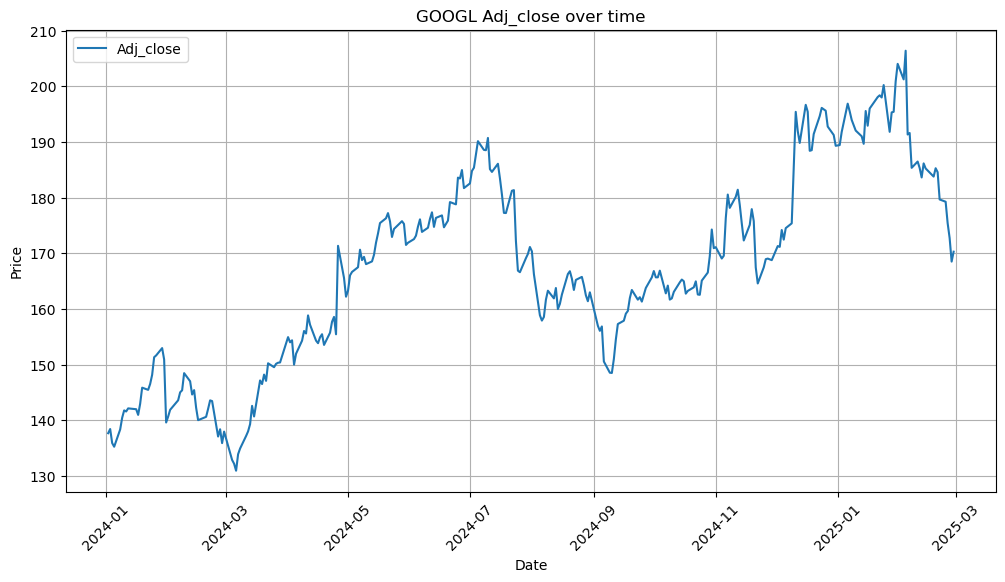

In [50]:
def plot_stock(df: pd.DataFrame, title: str, columns: str = 'Adj_close', begin_y: int = 2024) -> None:
    """
    Plot the time series of stock prices for a given stock.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing stock data with at least 'Title' and 'Date' columns.
    title : str
        The title (name) of the stock to be plotted.
    columns : str, optional
        The column(s) to plot (default is 'Adj_close').
    begin_y : int, optional
        The starting year for filtering the data (default is 2024).

    Returns
    -------
    None
        Displays the plot.
    """
    df_test = df[df['Title'] == title].copy()
    df_test = df_test[df_test["Date"].dt.year >= begin_y]
    plt.figure(figsize=(12, 6))

    for col in columns:
        plt.plot(df_test["Date"], df_test[col], linestyle="-", label=col)
        plt.title(f"{title} {col} over time")

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    del df_test

columns = ['Adj_close']

plot_stock(df, 'GOOGL', columns=columns)


In [51]:
for var in df.columns:
    if var in ['Date', 'Title', "Year", "Month", "Day"]: continue
    df[var] = df.groupby('Title')[var].pct_change()

df.dropna(inplace=True)


In [53]:
df['Adj_close'] = df['Adj_close'] / 100  

In [16]:
test_stationarity_per_stock(df)

,Title,ADF Statistic,p-value,Stationary
0,AAPL,-0.568485,0.877945,False
1,AMZN,-0.521927,0.887666,False
2,AVGO,-0.268216,0.929887,False
3,CSCO,-0.449531,0.901495,False
4,GC=F,0.727255,0.990366,False
5,GOOGL,-0.946683,0.772211,False
6,HG=F,-2.141062,0.228327,False
7,META,0.569948,0.986851,False
8,MSFT,-0.790074,0.822020,False
9,NOK,-2.371752,0.149869,False


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

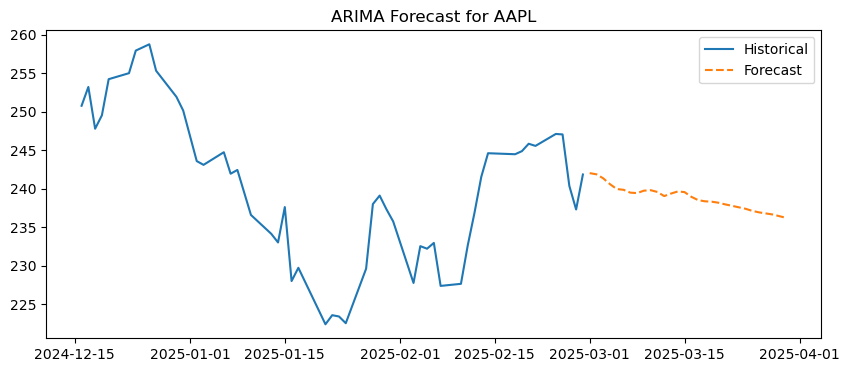

In [ ]:
from typing import Dict
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

def forecast_stock_prices(df: pd.DataFrame, num_stocks: int = 3, steps: int = 30) -> pd.DataFrame:
    """
    Forecast stock prices using an ARIMA model and plot the results.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing stock data with 'Title', 'Date', and 'Adj_close' columns.
    num_stocks : int, optional
        Number of stocks to forecast (default is 3).
    steps : int, optional
        Number of future time steps to forecast (default is 30).

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the forecasted values for each stock.
    """
    # Sort the DataFrame to ensure time series order
    df.sort_values(by=['Title', 'Date'], inplace=True)

    forecast_results: Dict[str, pd.Series] = {}

    # Loop over unique stock titles (limited to `num_stocks`)
    for title in df['Title'].unique()[:num_stocks]:
        df_title = df[df['Title'] == title].set_index('Date')
        series = df_title['Adj_close'].dropna()

        if len(series) < 22:  # Ensure sufficient data points for ARIMA(20,0,2)
            print(f"Skipping {title}: Not enough data points.")
            continue

        # Fit ARIMA model
        model = sm.tsa.ARIMA(series, order=(20, 0, 2))
        model_fit = model.fit()

        # Forecast the next `steps` days
        forecast = model_fit.forecast(steps=steps)

        # Generate forecast index with inferred frequency
        freq = pd.infer_freq(series.index)
        forecast_index = pd.date_range(start=series.index[-1], periods=steps + 1, freq=freq)[1:]

        # Store forecast results
        forecast_results[title] = pd.Series(forecast, index=forecast_index)

        # Plot the forecast
        plt.figure(figsize=(10, 4))
        plt.plot(series[-50:], label='Historical')
        plt.plot(forecast_index, forecast, label='Forecast', linestyle='dashed')
        plt.title(f"ARIMA Forecast for {title}")
        plt.legend()
        plt.show()

    # Convert forecast results to DataFrame
    forecast_df = pd.DataFrame(forecast_results)
    return forecast_df, forecast_index

forecast_df, forecast_index = forecast_stock_prices(df, 1)
# print(forecast_df)


In [18]:
forecast_index

DatetimeIndex(['2025-03-01', '2025-03-02', '2025-03-03', '2025-03-04',
               '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-08',
               '2025-03-09', '2025-03-10', '2025-03-11', '2025-03-12',
               '2025-03-13', '2025-03-14', '2025-03-15', '2025-03-16',
               '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20',
               '2025-03-21', '2025-03-22', '2025-03-23', '2025-03-24',
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-03-29', '2025-03-30'],
              dtype='datetime64[ns]', freq='D')

In [57]:
def get_best_arima(series):
    """
    Fit a SARIMA model with weekly seasonality (m=7) to capture daily patterns.
    Optimized for faster computation.
    
    Parameters:
    - series: Pandas Series, the time series data.
    
    Returns:
    - model: The best SARIMA model.
    """
    model = pm.auto_arima(
        series,
        start_p=0, max_p=3,  # Limite p pour réduire le temps de calcul
        start_q=0, max_q=3,  # Limite q pour réduire le temps de calcul
        d=None,              # Let auto_arima determine the best 'd'
        start_P=0, max_P=2,  # Limite P (saisonnalité AR)
        start_Q=0, max_Q=2,  # Limite Q (saisonnalité MA)
        D=None,              # Let auto_arima determine the best 'D'
        m=7,                 # Saisonnalité hebdomadaire
        seasonal=True,       # Activer la saisonnalité
        stepwise=True,       # Utiliser l'approche stepwise pour accélérer
        trace=False,         # Désactiver les logs pour réduire l'output
        suppress_warnings=True,  # Supprimer les avertissements
        information_criterion='aic',  # Minimiser l'AIC
        max_order=20,        # Limiter le nombre total de combinaisons
        n_jobs=-1            # Utiliser tous les cœurs CPU pour paralléliser
    )
    return model


In [58]:
def get_best_arima_per_stock(df: pd.DataFrame) -> Dict[str, pm.arima.ARIMA]:
    """
    Finds the best ARIMA model for each stock in the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing stock data with at least 'Title', 'Date', and 'Adj_close' columns.

    Returns
    -------
    Dict[str, pm.arima.ARIMA]
        A dictionary where the keys are stock titles, and values are the best ARIMA models.
    """
    best_models = {}

    df = df.sort_values(by=['Title', 'Date']).copy()

    for title in df['Title'].unique():
        stock_data = df[df['Title'] == title].set_index('Date')
        series = stock_data['Adj_close'].dropna() 

        if len(series) < 30: 
            print(f"Skipping {title}: Not enough data points for ARIMA.")
            continue

        try:
            start_time = time.time()
            # Call the existing function to find the best ARIMA model
            model = get_best_arima(series)
            best_models[title] = model
            
            end_time = time.time()
            print(f"Calculated the best ARIMA for {title} in {end_time - start_time:.2f} seconds.")
            print(f"Best ARIMA for {title}: {model.order} (AIC={model.aic():.2f}, BIC={model.bic():.2f})")

        except Exception as e:
            print(f"Error for {title}: {e}")

    return best_models

best_arima_models = get_best_arima_per_stock(df)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for AAPL in 4.02 seconds.
Best ARIMA for AAPL: (0, 0, 0) (AIC=-10933.04, BIC=-10928.41)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for AMZN in 4.98 seconds.
Best ARIMA for AMZN: (0, 0, 0) (AIC=-10453.59, BIC=-10448.97)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for AVGO in 3.01 seconds.
Best ARIMA for AVGO: (0, 0, 0) (AIC=-10235.87, BIC=-10231.24)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for CSCO in 2.59 seconds.
Best ARIMA for CSCO: (0, 0, 0) (AIC=-11152.99, BIC=-11148.37)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for GC=F in 5.66 seconds.
Best ARIMA for GC=F: (0, 0, 1) (AIC=-11857.83, BIC=-11843.95)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for GOOGL in 3.78 seconds.
Best ARIMA for GOOGL: (0, 0, 0) (AIC=-10648.20, BIC=-10643.58)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for HG=F in 4.34 seconds.
Best ARIMA for HG=F: (0, 0, 0) (AIC=-11162.95, BIC=-11158.32)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for META in 4.85 seconds.
Best ARIMA for META: (0, 0, 0) (AIC=-10129.75, BIC=-10125.13)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for MSFT in 7.74 seconds.
Best ARIMA for MSFT: (0, 0, 0) (AIC=-10921.26, BIC=-10916.64)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for NOK in 5.32 seconds.
Best ARIMA for NOK: (0, 0, 0) (AIC=-10676.26, BIC=-10671.64)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for NTTYY in 18.94 seconds.
Best ARIMA for NTTYY: (0, 0, 1) (AIC=-11522.99, BIC=-11513.75)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for NVDA in 4.87 seconds.
Best ARIMA for NVDA: (0, 0, 0) (AIC=-9858.09, BIC=-9853.47)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for PA=F in 2.99 seconds.
Best ARIMA for PA=F: (0, 0, 0) (AIC=-5788.73, BIC=-5780.55)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for PL=F in 2.70 seconds.
Best ARIMA for PL=F: (0, 0, 0) (AIC=-6526.20, BIC=-6522.06)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for QCOM in 6.65 seconds.
Best ARIMA for QCOM: (0, 0, 1) (AIC=-10396.74, BIC=-10387.49)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for SI=F in 3.82 seconds.
Best ARIMA for SI=F: (0, 0, 0) (AIC=-10328.93, BIC=-10324.35)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for T in 4.69 seconds.
Best ARIMA for T: (0, 0, 0) (AIC=-11081.66, BIC=-11077.03)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for TCEHY in 14.96 seconds.
Best ARIMA for TCEHY: (1, 0, 0) (AIC=-10169.72, BIC=-10155.85)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for TMUS in 8.80 seconds.
Best ARIMA for TMUS: (0, 0, 0) (AIC=-11269.12, BIC=-11255.24)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Calculated the best ARIMA for TSLA in 5.75 seconds.
Best ARIMA for TSLA: (0, 0, 0) (AIC=-9713.81, BIC=-9709.19)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for TSM in 5.42 seconds.
Best ARIMA for TSM: (0, 0, 0) (AIC=-10425.78, BIC=-10421.16)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\u

Calculated the best ARIMA for VZ in 19.01 seconds.
Best ARIMA for VZ: (0, 0, 0) (AIC=-11227.78, BIC=-11213.91)


In [63]:
print(best_arima_models)

{'AAPL': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False), 'AMZN': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False), 'AVGO': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False), 'CSCO': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False), 'GC=F': ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True), 'GOOGL': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False), 'HG=F': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False), 'META': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, wit

In [64]:
for title, model in best_arima_models.items():
    if hasattr(model, 'aic') and hasattr(model, 'bic'):  # Vérifier que le modèle a les attributs nécessaires
        print(f"Stock: {title}")
        print(f"  ARIMA Order: {model.order}")
        print(f"  AIC: {model.aic():.2f}")
        print(f"  BIC: {model.bic():.2f}")
        print("-" * 40)
    else:
        print(f"Stock: {title} - Modèle invalide ou non entraîné.")

Stock: AAPL
  ARIMA Order: (0, 0, 0)
  AIC: -10933.04
  BIC: -10928.41
----------------------------------------
Stock: AMZN
  ARIMA Order: (0, 0, 0)
  AIC: -10453.59
  BIC: -10448.97
----------------------------------------
Stock: AVGO
  ARIMA Order: (0, 0, 0)
  AIC: -10235.87
  BIC: -10231.24
----------------------------------------
Stock: CSCO
  ARIMA Order: (0, 0, 0)
  AIC: -11152.99
  BIC: -11148.37
----------------------------------------
Stock: GC=F
  ARIMA Order: (0, 0, 1)
  AIC: -11857.83
  BIC: -11843.95
----------------------------------------
Stock: GOOGL
  ARIMA Order: (0, 0, 0)
  AIC: -10648.20
  BIC: -10643.58
----------------------------------------
Stock: HG=F
  ARIMA Order: (0, 0, 0)
  AIC: -11162.95
  BIC: -11158.32
----------------------------------------
Stock: META
  ARIMA Order: (0, 0, 0)
  AIC: -10129.75
  BIC: -10125.13
----------------------------------------
Stock: MSFT
  ARIMA Order: (0, 0, 0)
  AIC: -10921.26
  BIC: -10916.64
--------------------------------

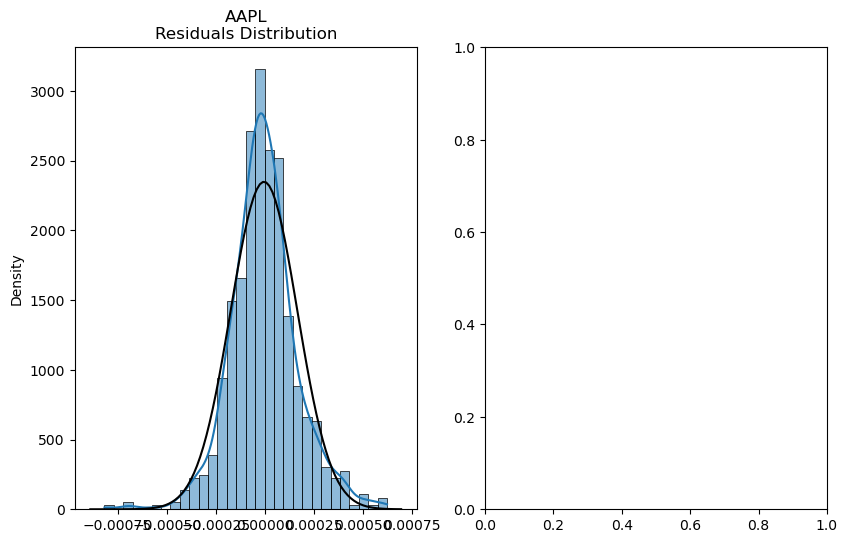

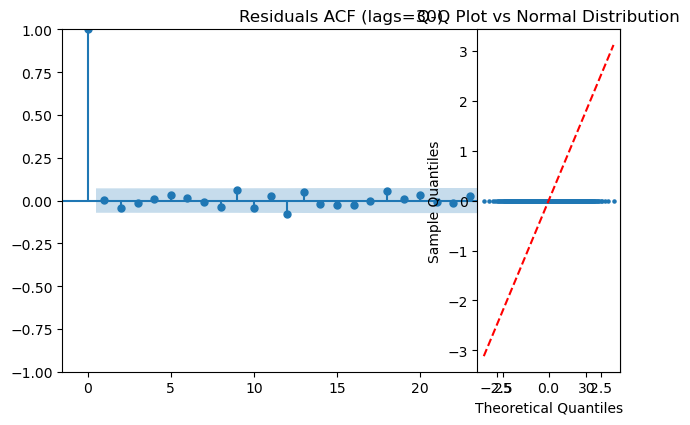


📊 AAPL - Residual Analysis:
Ljung-Box p-value (lag 30): 0.5561
Shapiro-Wilk p-value: 0.0000
Residual Stats:
Mean: -0.0000
Std Dev: 0.0002
Skewness: 0.1049
Kurtosis: 2.0282
--------------------------------------------------


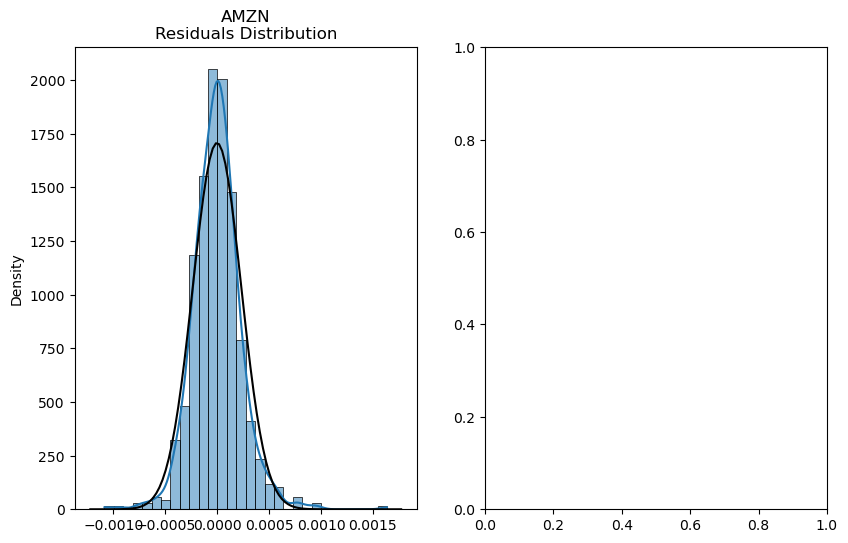

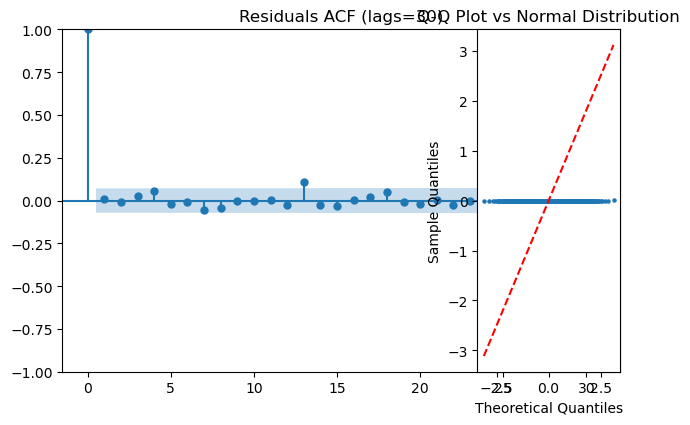


📊 AMZN - Residual Analysis:
Ljung-Box p-value (lag 30): 0.5879
Shapiro-Wilk p-value: 0.0000
Residual Stats:
Mean: -0.0000
Std Dev: 0.0002
Skewness: 0.5428
Kurtosis: 4.7903
--------------------------------------------------


In [65]:
def analyze_residuals(models_dict: dict, x: int = 10, figsize: tuple = (15, 6), 
                     bins: int = 30, lags: int = 30, alpha: float = 0.05):
    """
    Analyze residuals for the first 'x' ARIMA models with enhanced diagnostics.
    
    Parameters:
    - models_dict: Dictionary of ARIMA models {title: model}
    - x: Number of models to analyze (first x entries)
    - figsize: Figure size for plots
    - bins: Number of bins for histograms
    - lags: Number of lags for ACF and Ljung-Box test
    - alpha: Significance level for statistical tests
    """
    
    for title, model in itertools.islice(models_dict.items(), x):
        try:
            residuals = model.resid()
            
            if len(residuals) == 0:
                print(f"No residuals available for {title}")
                continue

            plt.figure(figsize=figsize)
            
            # Enhanced Histogram with PDF comparison
            plt.subplot(1, 3, 1)
            sns.histplot(residuals, bins=bins, kde=True, stat='density', 
                        edgecolor='black', linewidth=0.5)
            xmin, xmax = plt.xlim()
            x_pdf = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x_pdf, np.mean(residuals), np.std(residuals))
            plt.plot(x_pdf, p, 'k', linewidth=1.5)
            plt.title(f"{title}\nResiduals Distribution")
            
            # ACF Plot with enhanced parameters
            plt.subplot(1, 3, 2)
            plot_acf(residuals, lags=lags, alpha=alpha, 
                    title=f"Residuals ACF (lags={lags})")
            
            # Q-Q Plot for normality check
            plt.subplot(1, 3, 3)
            (osm, osr), _ = probplot(residuals, dist='norm', fit=True)
            plt.scatter(osm, osr, s=5)
            plt.plot(osm, osm, color='red', linestyle='--')
            plt.title("Q-Q Plot vs Normal Distribution")
            plt.xlabel("Theoretical Quantiles")
            plt.ylabel("Sample Quantiles")
            
            plt.tight_layout()
            plt.show()

            # Statistical tests
            print(f"\n📊 {title} - Residual Analysis:")
            
            # 1. Ljung-Box Test for autocorrelation
            lb_test = acorr_ljungbox(residuals, lags=[lags])
            print(f"Ljung-Box p-value (lag {lags}): {lb_test.iloc[-1, -1]:.4f}")
            
            # 2. Shapiro-Wilk test for normality
            shapiro_test = shapiro(residuals)
            print(f"Shapiro-Wilk p-value: {shapiro_test[1]:.4f}")
            
            # 3. Residual summary statistics
            print(f"Residual Stats:\nMean: {np.mean(residuals):.4f}")
            print(f"Std Dev: {np.std(residuals):.4f}")
            print(f"Skewness: {residuals.skew():.4f}")
            print(f"Kurtosis: {residuals.kurtosis():.4f}")
            print("-"*50)

        except Exception as e:
            print(f"Error analyzing {title}: {str(e)}")
            plt.close()

# Example usage
analyze_residuals(best_arima_models, x=2, lags=30)

c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

📊 PL=F - MAE: 0.0002


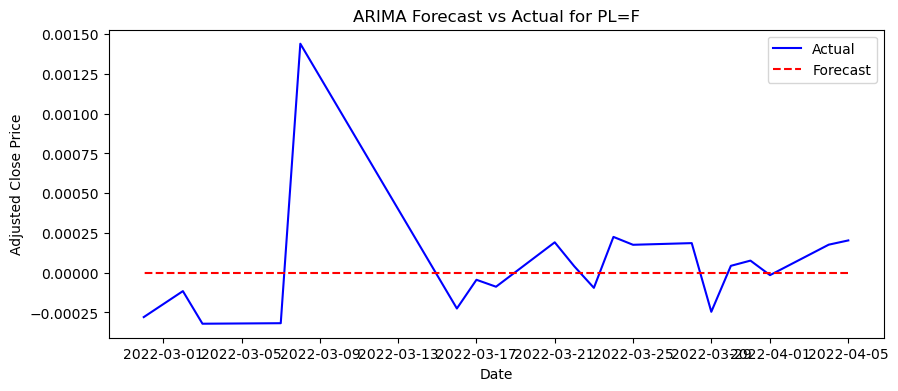

c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

📊 GOOGL - MAE: 0.0002


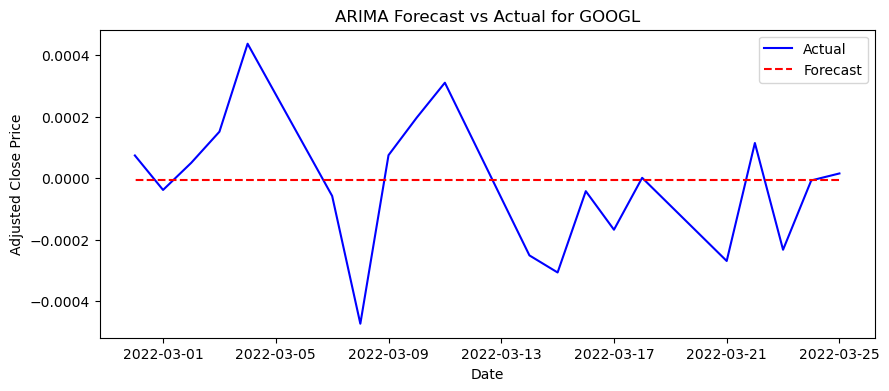

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

def forecast_with_best_models(models_dict: dict, df: pd.DataFrame, titles: list or str, 
                             test_size: int = 30, figsize: tuple = (10, 4)):
    """
    Forecast using the best ARIMA models for specified titles and evaluate performance.
    
    Parameters:
    - models_dict: Dictionary of ARIMA models {title: model}
    - df: DataFrame containing the time series data
    - titles: Single title (str) or list of titles to forecast
    - test_size: Number of observations to use as test set
    - figsize: Figure size for plots
    """
    # Convert single title to list for uniform processing
    if isinstance(titles, str):
        titles = [titles]
    
    for title in titles:
        if title not in models_dict:
            print(f"⚠️ Model for {title} not found in the dictionary. Skipping...")
            continue
        
        # Extract the series for the title
        series = df[df['Title'] == title].set_index('Date')['Adj_close']
        
        # Split into train and test sets
        train = series.iloc[:-test_size]
        test = series.iloc[-test_size:]
        
        # Get the best model order from the dictionary
        best_model = models_dict[title]
        order = best_model.order
        seasonal_order = best_model.seasonal_order
        
        # Fit the final ARIMA model on the training data
        final_model = sm.tsa.ARIMA(train, order=order, seasonal_order=seasonal_order).fit()
        
        # Forecast the test set
        forecast = final_model.forecast(steps=len(test))
        
        # Evaluate with Mean Absolute Error (MAE)
        mae = mean_absolute_error(test, forecast)
        print(f"📊 {title} - MAE: {mae:.4f}")
        
        # Plot actual vs forecasted values
        plt.figure(figsize=figsize)
        plt.plot(test.index, test, label="Actual", color="blue")
        plt.plot(test.index, forecast, label="Forecast", color="red", linestyle="dashed")
        plt.legend()
        plt.title(f"ARIMA Forecast vs Actual for {title}")
        plt.xlabel("Date")
        plt.ylabel("Adjusted Close Price")
        plt.show()

# Example usage
forecast_with_best_models(best_arima_models, df, titles=["PL=F", "GOOGL"], test_size=20)

In [67]:
df.head(25)

,Title,Date,Open,High,Low,Close,Adj_close,Volume,Year,Month,Day
1,AAPL,2025-02-27,0.010382,0.001528,0.029800,-0.018773,-0.000188,-0.275416,2025,2,27
2,AAPL,2025-02-26,0.020551,0.010393,0.008732,0.012895,0.000129,0.079701,2025,2,26
3,AAPL,2025-02-25,0.015021,0.020491,0.024171,0.027792,0.000278,0.080563,2025,2,25
4,AAPL,2025-02-24,-0.012379,-0.004560,-0.002001,0.000243,0.000002,0.069004,2025,2,24
5,AAPL,2025-02-21,0.004164,-0.000683,0.003273,-0.006273,-0.000063,0.036453,2025,2,21
6,AAPL,2025-02-20,-0.004107,-0.007680,-0.003793,0.001140,0.000011,-0.392510,2025,2,20
7,AAPL,2025-02-19,-0.001143,-0.003120,-0.004626,-0.003905,-0.000039,-0.003487,2025,2,19
8,AAPL,2025-02-18,-0.002085,-0.003374,-0.005429,-0.001634,-0.000016,0.516029,2025,2,18
9,AAPL,2025-02-14,-0.011878,0.001509,-0.003515,0.000532,0.000005,-0.162349,2025,2,14
10,AAPL,2025-02-13,-0.017990,-0.013073,-0.022491,-0.012551,-0.000126,0.310980,2025,2,13
